In [4]:
%matplotlib inline
import scipy.stats as stats
from IPython.core.pylabtools import figsize
import numpy as np
figsize(12.5, 4)

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

import pymc3 as pm
import theano.tensor as T

[115.85679142 152.26153716 178.87449059 162.93500815 107.02820697
 105.19141146 118.38288501 125.3769803  102.88054011 206.71326136] ...


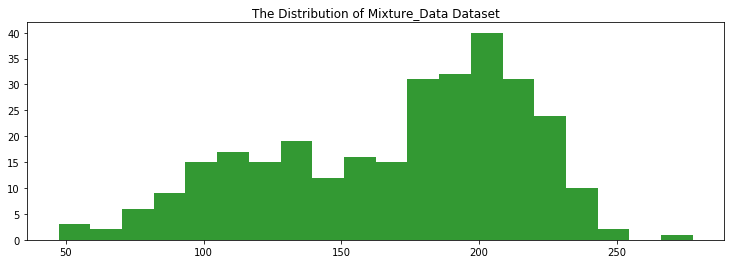

In [5]:
figsize(12.5, 4)
data = np.loadtxt("../data/mixture_data.csv", delimiter=",")

plt.hist(data, bins=20, color="g", histtype="stepfilled", alpha=0.8)
plt.title("The Distribution of Mixture_Data Dataset")
plt.ylim([0, None]);
print(data[:10], "...")

In [6]:
with pm.Model() as model:
    p1 = pm.Uniform('p', 0, 1)
    p2 = 1 - p1
    p = T.stack([p1, p2])
    assignment = pm.Categorical("assignment", p, 
                                shape=data.shape[0],
                                testval=np.random.randint(0, 2, data.shape[0]))
    
print("prior assignment, with p = %.2f:" % p1.tag.test_value)
print(assignment.tag.test_value[:10])

prior assignment, with p = 0.50:
[0 1 1 0 1 0 1 1 0 0]


### Note

* The data is showing 2 peaks, might be binominal distribution. So the prior has p1, p2 to form cluster 1, 2
* Since we don't know the probability of each data of getting into cluster 1 or 2, so uniformly assign the data to each cluster